In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
import plotly.express as px
import os
import seaborn as sns


In [2]:
wines = pd.read_csv('datasets/winequality-all.csv')
wines.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.4              0.70         0.00             1.9   
1     1            7.8              0.88         0.00             2.6   
2     1            7.8              0.76         0.04             2.3   
3     1           11.2              0.28         0.56             1.9   
4     1            7.4              0.70         0.00             1.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.076                 11.0                  34.0   0.9978  3.51   
1      0.098                 25.0                  67.0   0.9968  3.20   
2      0.092                 15.0                  54.0   0.9970  3.26   
3      0.075                 17.0                  60.0   0.9980  3.16   
4      0.076                 11.0                  34.0   0.9978  3.51   

   sulphates  alcohol  quality  
0       0.56      9.4        5  
1       0.68      9.8        5  
2       0.65      9.8        5  
3       0.58      9.8        6  
4       0.56      9.4        5

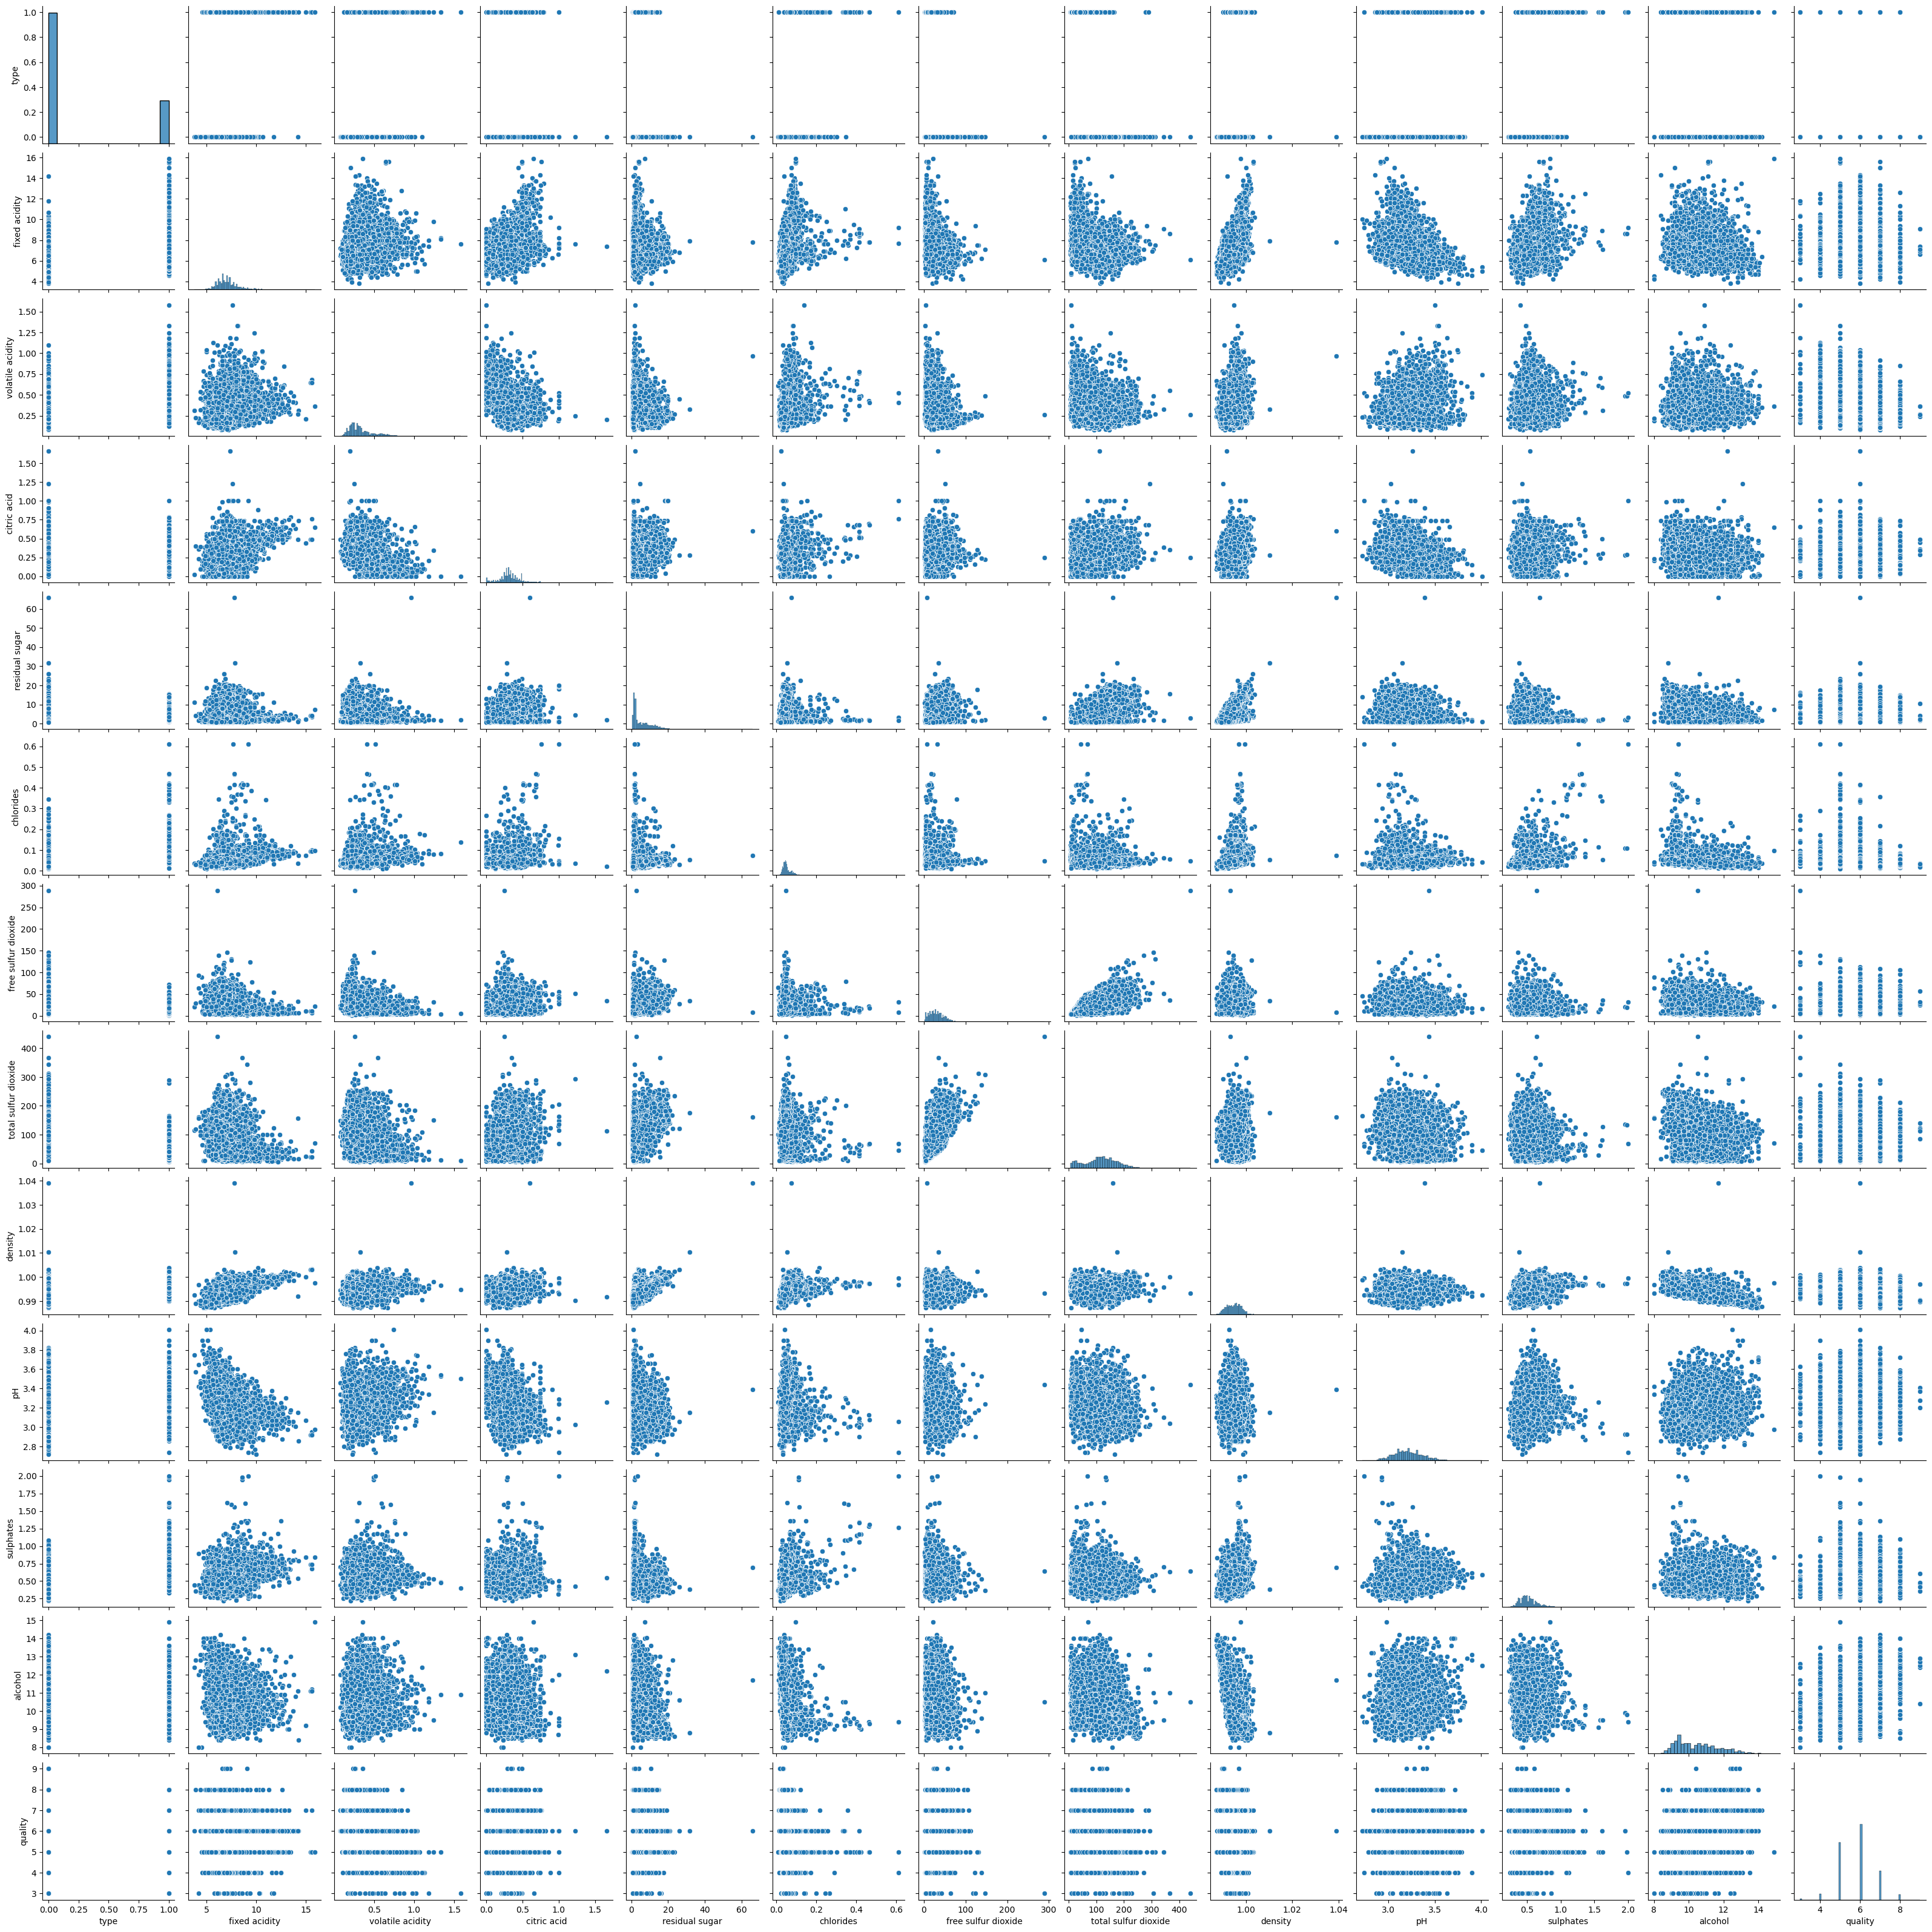

In [3]:
sns.pairplot(wines)

Looks like most of the distributions are Logonormal or Chi-squared. One or two are Weibull. Let's try 3 different transformers on independent variables: Box-cox, Qualtile, and Yeo-Johnson transformers. We'll rate them by skeweness of tranformed distribution, and choose the one that has the least skeweness.

In [4]:
def tranforming_params(col):
    
    skewnesses = {}
    
    # let's isolate variable
    x_var = wines.loc[:,col]
    
    #let's try box-cox transformer first
    if not (True in (x_var < 1).unique()):
        x_var_transf,_ = boxcox(x_var)
        skewnesses['boxcox'] = pd.DataFrame(x_var_transf).skew()

    
    x_var = np.array(wines.loc[:,col])
    
    #let's try quantile transformer next
    quantile_transformer = QuantileTransformer(n_quantiles=3, random_state=0)
    x_var_transf = quantile_transformer.fit_transform(x_var.reshape(-1, 1))
    skewnesses['quantile'] = pd.DataFrame(x_var_transf).skew()

    # Apply the Yeo-Johnson transformation to the features
    pt = PowerTransformer(method="yeo-johnson", standardize=True)
    x_var_transf = pt.fit_transform(x_var.reshape(-1,1))
    skewnesses['yeo-johnson'] = pd.DataFrame(x_var_transf).skew()
    
    return skewnesses
    

In [5]:
wines_for_test = wines.drop('quality', axis =1)
#wines_for_test = wines_for_test.drop('type', axis =1)

best_for_col = {}

for col_name in wines_for_test.columns:
    
    tests = pd.DataFrame(tranforming_params(col_name))
    best_for_col[col_name] = tests.idxmin(1)[0]

best_for_col.values()

dict_values(['quantile', 'boxcox', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile'])

In [6]:
transf_counts = {'quantile':0, 'boxcox':0, 'yeo-johnson': 0}

for value in best_for_col.values():
    transf_counts[value] = transf_counts[value] + 1
    
print(f'The best tranformer for our dataset is {max(transf_counts, key= lambda k:transf_counts[k])} tranformer; Let\'s tranform our dataset accordingly')

The best tranformer for our dataset is quantile tranformer; Let's tranform our dataset accordingly


In [20]:
# Initialize the QuantileTransformer object
qt = QuantileTransformer(output_distribution='normal')

# Apply quantile transformation on the dataframe
wines_transformed = pd.DataFrame(qt.fit_transform(wines.drop('quality', axis=1)), columns=wines.drop('quality', axis=1).columns)

wines_transformed['quality'] = wines['quality'] 

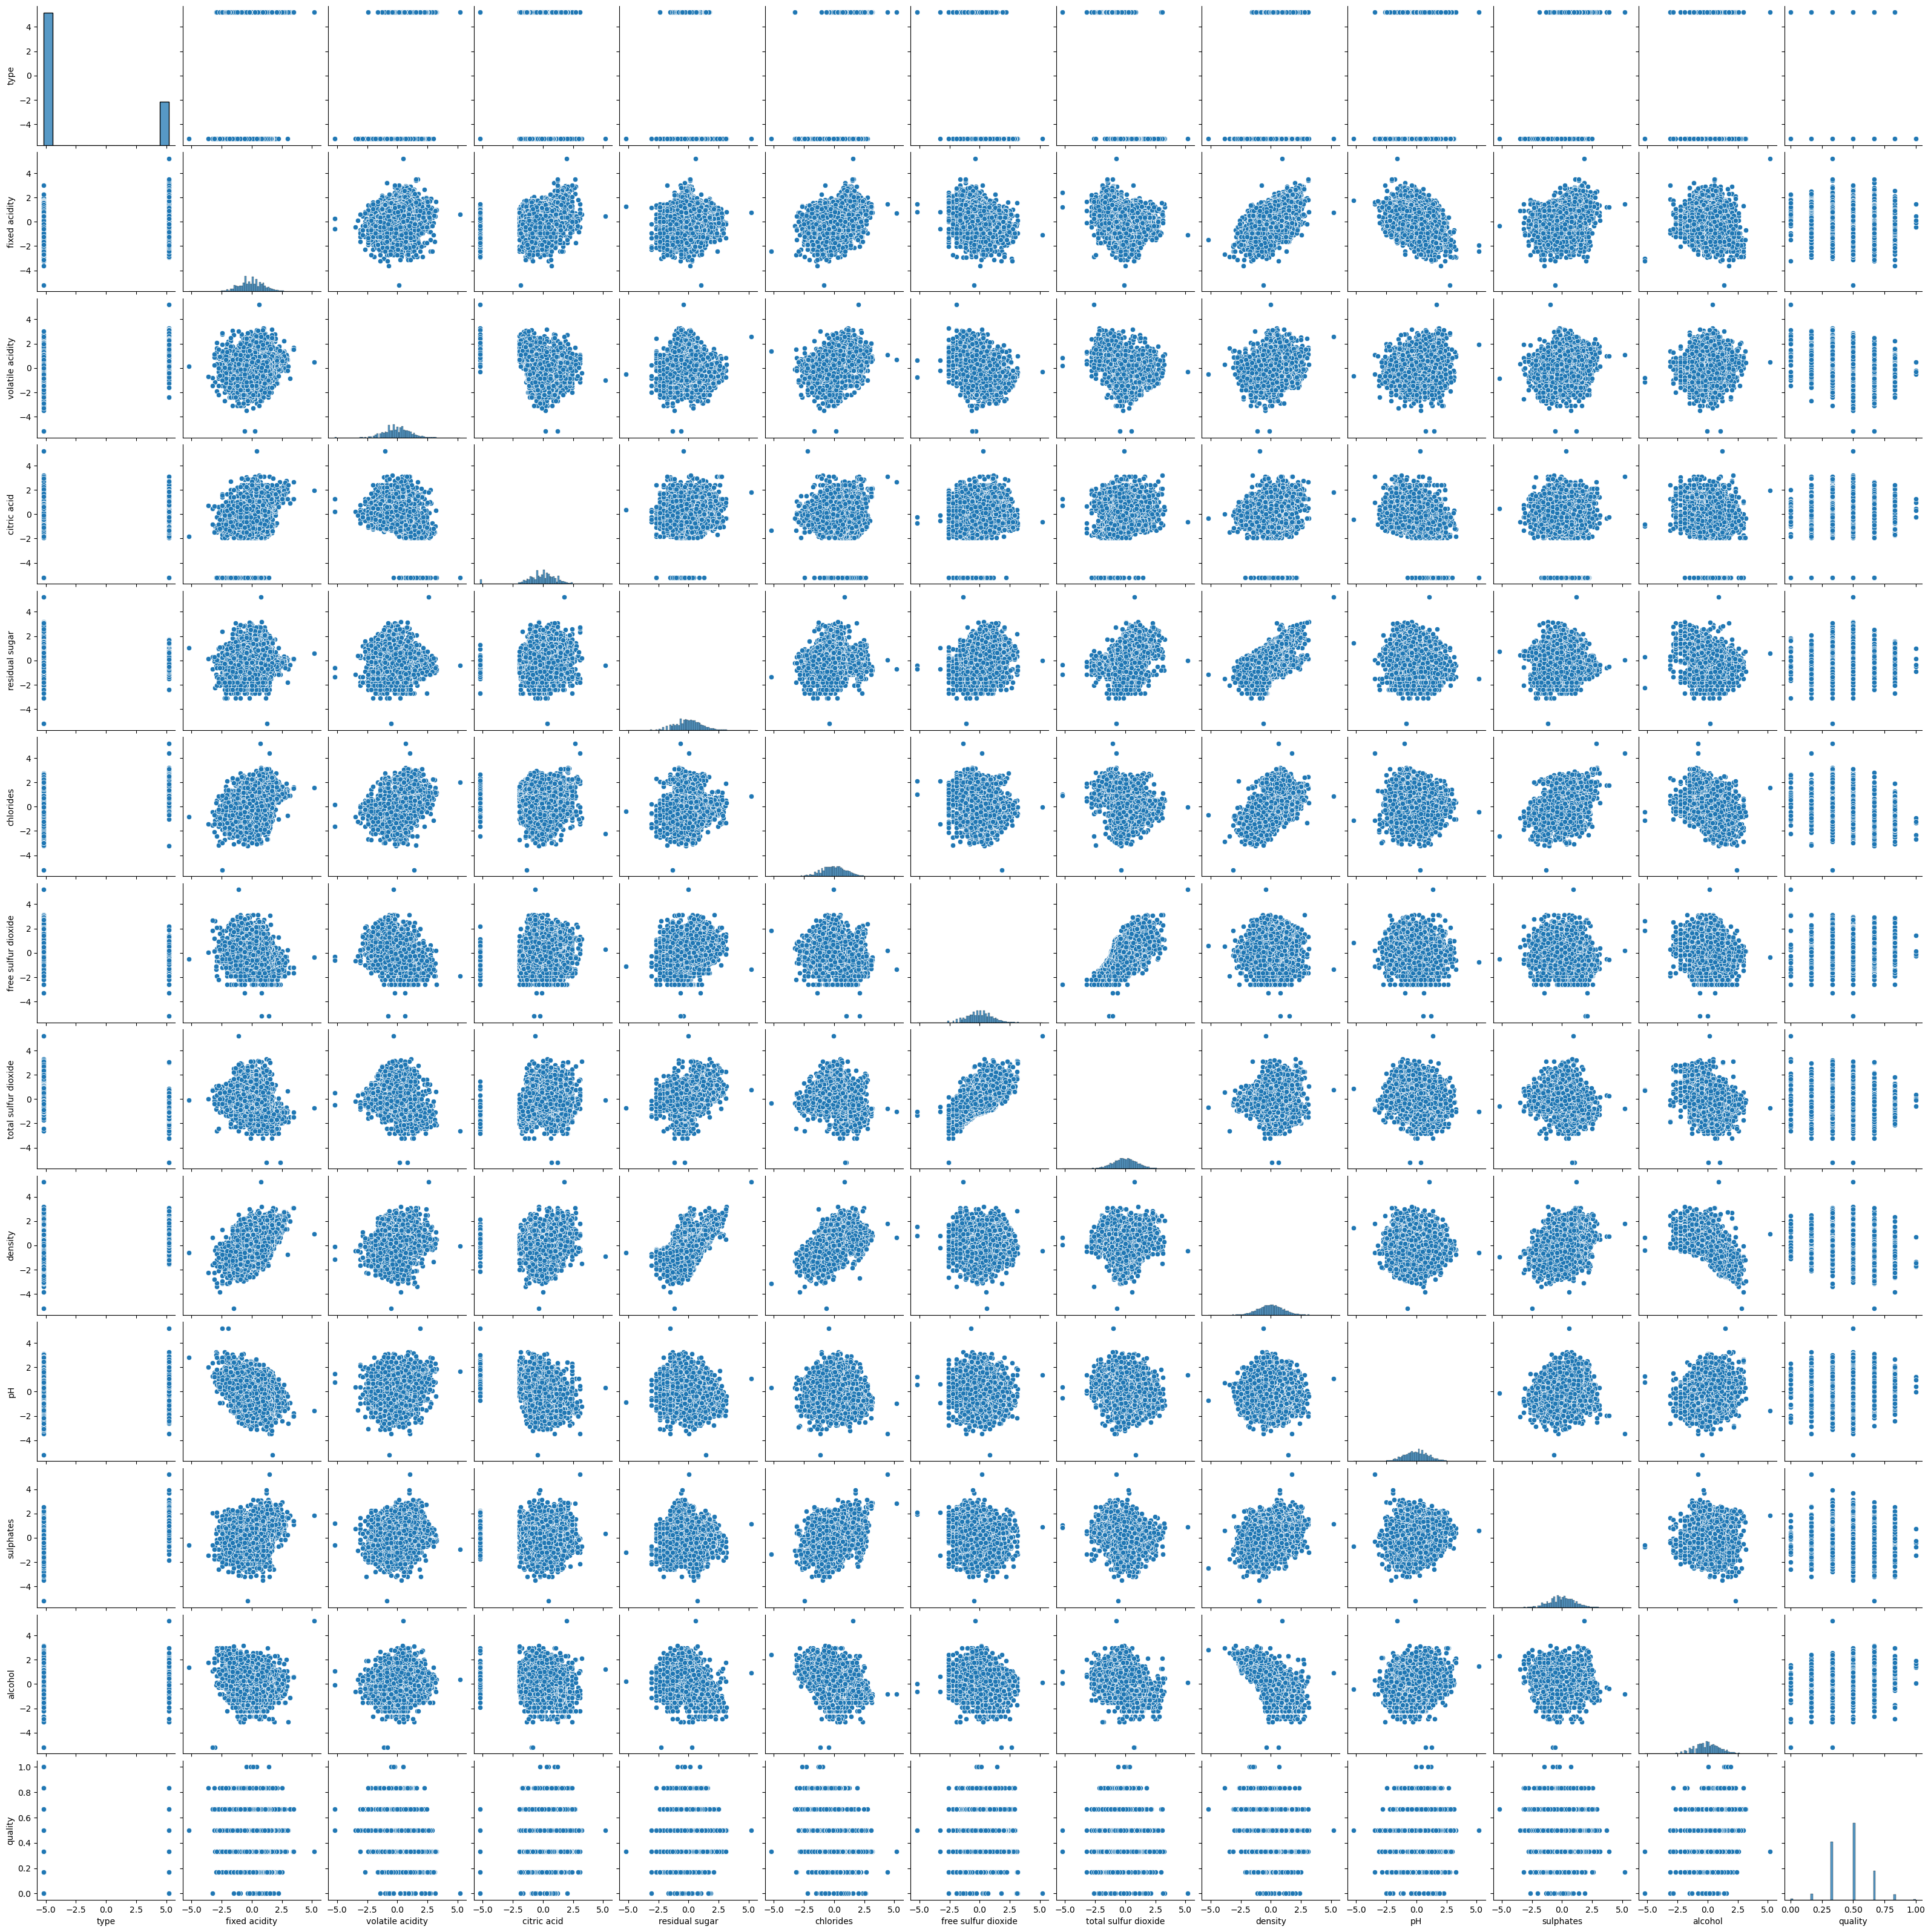

In [21]:
sns.pairplot(wines_transformed)

In [3]:
# separate the target variable (quality) from the features
x = wines.drop('quality', axis=1)
y = wines['quality']

# split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [4]:
# print the shape of the training and test sets
print('Training set shape:', x_train.shape, y_train.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Training set shape: (5197, 12) (5197,)
Test set shape: (1300, 12) (1300,)
